# Import modules and load data

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import pickle 

import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import pickle
import operator
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import time
acc = make_scorer(accuracy_score)


from sklearn.multiclass import OneVsRestClassifier

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
import random

def sampleData(DataFrame, ratio):
    df_size = len(DataFrame.index)
    sample_size = int(round(ratio * df_size))
    if sample_size == df_size:
        sample_size = sample_size - 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    elif sample_size == 0:
        sample_size = 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    else:
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

In [4]:
#import data
atlas = pd.read_csv('/home/compomics/git/Tissue_prediction/PTM_predictor/Atlases/tissue_predictor_healthy_nofluid_filtered90%_proteinlevel_20231810.csv')

atlas.head()

A0A075B6H7  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6K5  A0A075B6Q5  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   A0A075B6R2  A0A075B6S4  A0A075B6S5  A0A087WSY6  ...  Q9Y6X0  Q9Y6X3  \
0         0.0         0.0         0.0         0.0  ...     0.0     0.0   
1         0.0         0.0         0.0         0.0  ...     0.0     0.0   
2         0.0         0.0         0.0         0.0  ...     0.0     0.0   
3         0.0         0.0         0.0         0.0  ...     0.0     0.0   
4         0.0         0.0         0.0         0.0  ...     0.0     0.0   

   Q9Y6X5  Q9Y6X8  Q9Y6X9  Q9Y6Y0  Q9Y6Y8  tissue_name          cell_type  \
0     0.0     0.0     0.0     0.0     0.0        Brain  Prefrontal cortex   
1     0.0     0.0     0.0     0.0     0.0        Brain  Prefrontal cortex   
2     0.0     0.0     0.0     0.0     0.0        Brain  Prefrontal cortex   
3     0.0     0.0     0.0     0.0     0.0        Brain  Prefrontal cortex   
4     0.0     0.0     0.0     0.0     0.0        Brain  Prefrontal cortex   

   disease_status  
0         Healthy  
1         Healthy  
2         Healthy  
3         Healthy  
4         Healthy  

[5 rows x 6880 columns]

In [5]:
print(atlas.shape)

(1021, 6880)


In [6]:
i=0
for column_name in atlas.columns:
    column = atlas[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    i+=1
    if i == 25:
        break
    print('Count of zeros in column ', column_name, ' is : ', count)

Count of zeros in column  A0A075B6H7  is :  962
Count of zeros in column  A0A075B6H9  is :  1019
Count of zeros in column  A0A075B6I0  is :  995
Count of zeros in column  A0A075B6I1  is :  1019
Count of zeros in column  A0A075B6K5  is :  1019
Count of zeros in column  A0A075B6Q5  is :  1019
Count of zeros in column  A0A075B6R2  is :  1019
Count of zeros in column  A0A075B6S4  is :  1020
Count of zeros in column  A0A075B6S5  is :  1012
Count of zeros in column  A0A087WSY6  is :  1020
Count of zeros in column  A0A096LP55  is :  1019
Count of zeros in column  A0A0A0MS14  is :  1019
Count of zeros in column  A0A0A0MS15  is :  1005
Count of zeros in column  A0A0B4J1U3  is :  1019
Count of zeros in column  A0A0B4J1U7  is :  1006
Count of zeros in column  A0A0B4J1V0  is :  1000
Count of zeros in column  A0A0B4J1V1  is :  1020
Count of zeros in column  A0A0B4J1V2  is :  1020
Count of zeros in column  A0A0B4J1V6  is :  1010
Count of zeros in column  A0A0B4J1X5  is :  1020
Count of zeros in colu

In [7]:
exclude_tissues = ['Dental plaque', 'hMSC', 'Hela', 'Unknown', 'Urine', 'Cerebrospinal fluid', 'Tooth', 'Blood', 'Bone', 'Nasal Polyps', 'Nasal polyps']
atlas = atlas[~atlas['tissue_name'].isin(exclude_tissues)]
atlas = atlas.replace({'Cervix': 'Uterine cervix'})
atlas = atlas.replace({'Palatine tonsils': 'Tonsil'})
atlas = atlas.replace({'palatine tonsils': 'Tonsil'})
atlas = atlas.replace({'B-cell': 'B-cells'})
atlas = atlas.replace({'Monocyte': 'Monocytes'})

print(atlas.shape)

(690, 6880)


## Drop projects with too many missing values and with less than 2 PXDs associated with it

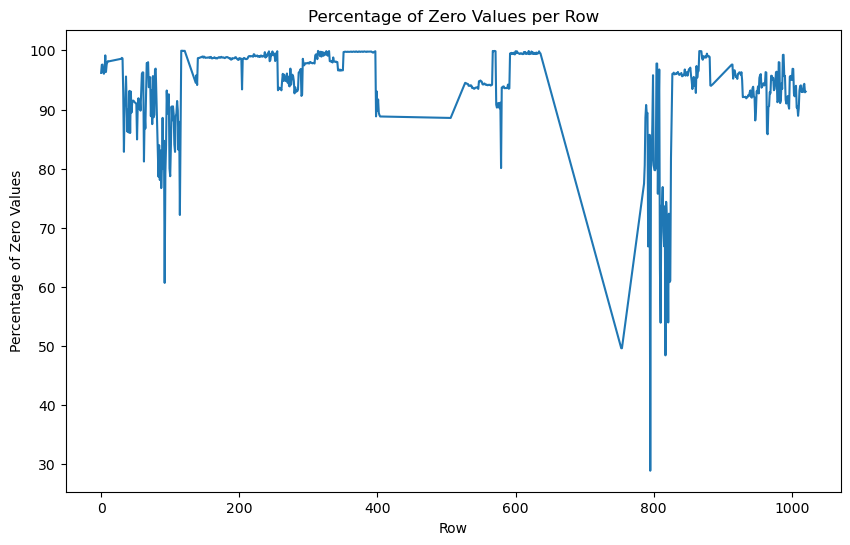

In [8]:
# Calculate the percentage of zero values per row
zero_percentage = (atlas.eq(0).sum(axis=1) / atlas.shape[1]) * 100

# Visualize the percentage of zero values per row with a line plot
zero_percentage.plot(kind='line', figsize=(10, 6))
plt.xlabel('Row')
plt.ylabel('Percentage of Zero Values')
plt.title('Percentage of Zero Values per Row')
plt.show()

In [9]:
max(zero_percentage)

99.94186046511628

In [10]:
#return the rows with the most amount of missingness
atlas[zero_percentage < 75]['tissue_name'].value_counts()

tissue_name
Testis             5
Pituitary gland    2
Placenta           2
Stomach            2
Tonsil             2
Duodenum           1
Endometrium        1
Oviduct            1
Rectum             1
Salivary gland     1
Small intestine    1
Smooth muscle      1
Spleen             1
Thyroid            1
Name: count, dtype: int64

In [11]:
#drop the rows that contain over 95% missingness and then drop all columns that only contain NaN values
atlas = atlas[zero_percentage < 95]
atlas = atlas[zero_percentage > 75]
atlas.dropna(axis=1, how='all')
atlas.shape

/tmp/ipykernel_36813/2108232346.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  atlas = atlas[zero_percentage > 75]


(259, 6880)

## Check the class balance

<Axes: ylabel='count'>

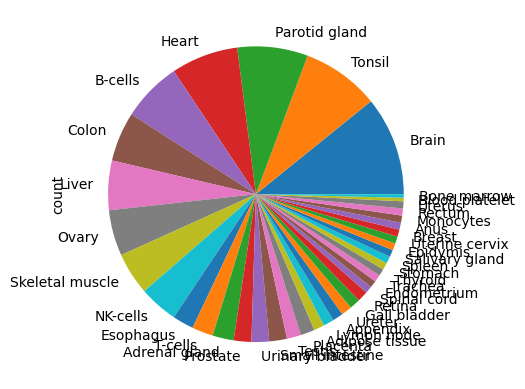

In [12]:
atlas['tissue_name'].value_counts().plot.pie()

<Axes: xlabel='tissue_name'>

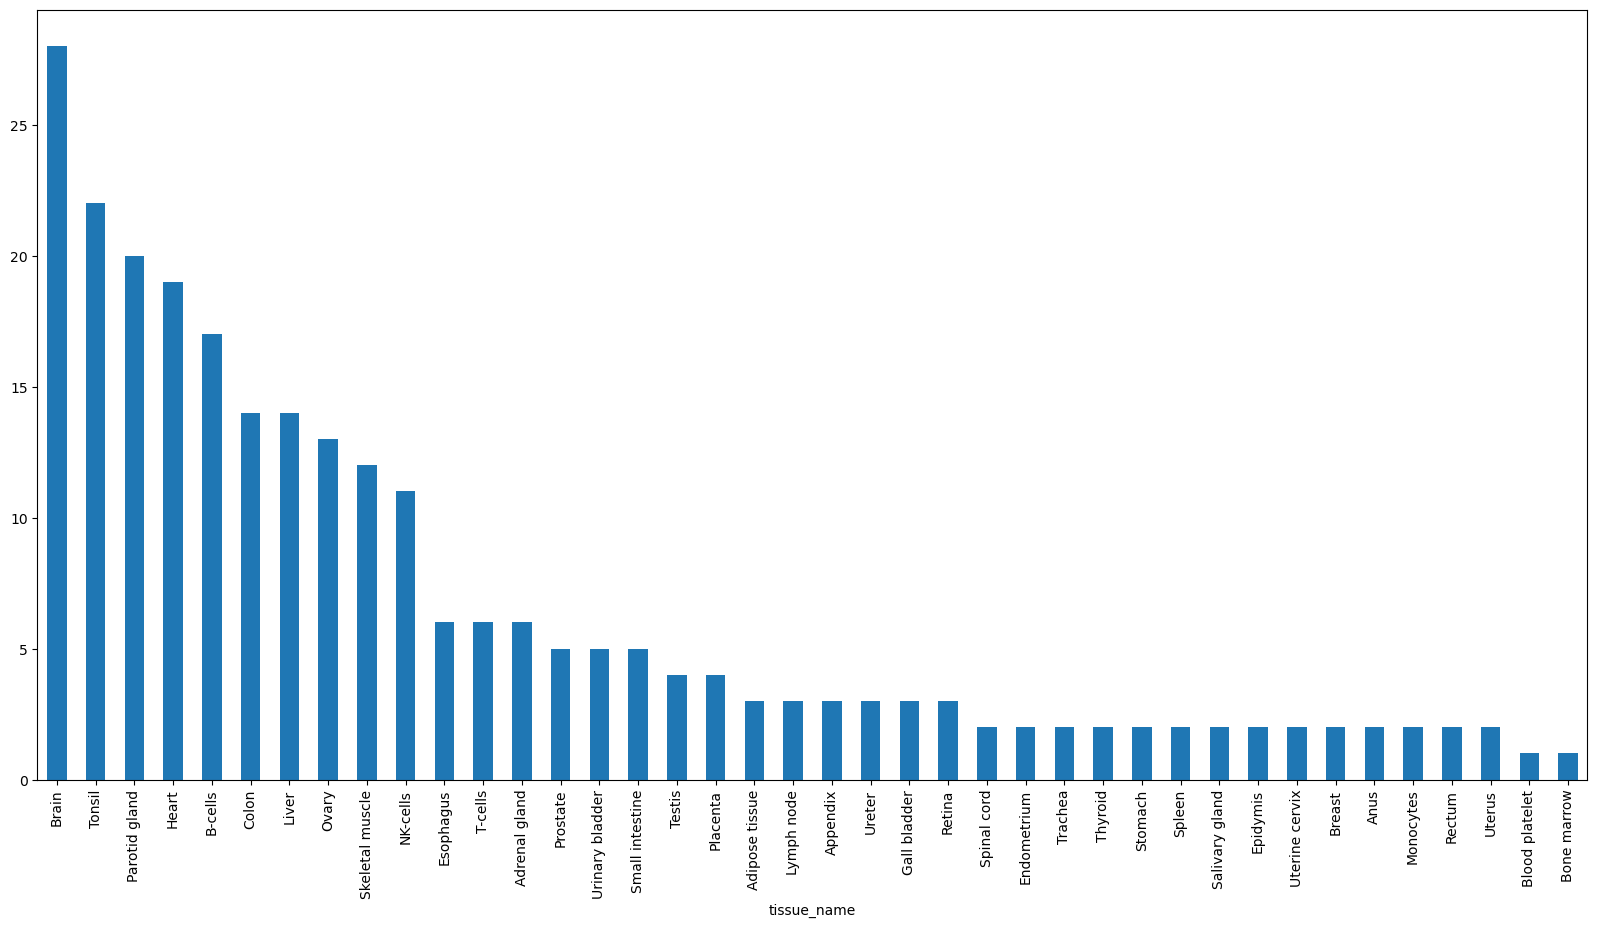

In [13]:
atlas['tissue_name'].value_counts().plot(kind='bar', figsize=(20,10))

We will balance the atlas a little bit by dropping the tissues that are too low. 

In [14]:
pd.set_option('display.max_rows', None)  
tissue_counts = atlas['tissue_name'].value_counts().to_frame()
print(tissue_counts)

                 count
tissue_name           
Brain               28
Tonsil              22
Parotid gland       20
Heart               19
B-cells             17
Colon               14
Liver               14
Ovary               13
Skeletal muscle     12
NK-cells            11
Esophagus            6
T-cells              6
Adrenal gland        6
Prostate             5
Urinary bladder      5
Small intestine      5
Testis               4
Placenta             4
Adipose tissue       3
Lymph node           3
Appendix             3
Ureter               3
Gall bladder         3
Retina               3
Spinal cord          2
Endometrium          2
Trachea              2
Thyroid              2
Stomach              2
Spleen               2
Salivary gland       2
Epidymis             2
Uterine cervix       2
Breast               2
Anus                 2
Monocytes            2
Rectum               2
Uterus               2
Blood platelet       1
Bone marrow          1


In [15]:
fluids=['Blood', 'Cerebrospinal fluid', 'Urine', 'Follicular fluid', 'Sputum', 'Blood platelet']
atlas = atlas[~atlas['tissue_name'].isin(fluids)]

# Drop low tissues

In [16]:
low_tissues = tissue_counts.reset_index()[tissue_counts.reset_index()['count'] <= 2]['tissue_name'].tolist()
atlas = atlas[~atlas['tissue_name'].isin(low_tissues)]

In [17]:
tf = dict(Counter(atlas['tissue_name']))
tf = sorted(tf.items(), key=operator.itemgetter(1), reverse=True)
tf = dict(tf)

# Using class weight in the predictors <br>
To further balance the algorithm, the class will be assigned a specific weight based on the number of samples in this class. 

The weight of a class is determined by dividing negative samples/ positive samples. So if a class contains 15 samples in a dataset of 100 samples, the class weight will be 85/15=5,667

In [18]:
atlas.head()

A0A075B6H7  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6K5  A0A075B6Q5  \
32         0.0         0.0         0.0         0.0         0.0         0.0   
33         0.0         0.0         0.0         0.0         0.0         0.0   
34         0.0         0.0         0.0         0.0         0.0         0.0   
35         0.0         0.0         0.0         0.0         0.0         0.0   
37         0.0         0.0         0.0         0.0         0.0         0.0   

    A0A075B6R2  A0A075B6S4  A0A075B6S5  A0A087WSY6  ...  Q9Y6X0  Q9Y6X3  \
32         0.0         0.0         0.0         0.0  ...     0.0     0.0   
33         0.0         0.0         0.0         0.0  ...     0.0     0.0   
34         0.0         0.0         0.0         0.0  ...     0.0     0.0   
35         0.0         0.0         0.0         0.0  ...     0.0     0.0   
37         0.0         0.0         0.0         0.0  ...     0.0     0.0   

    Q9Y6X5  Q9Y6X8  Q9Y6X9  Q9Y6Y0    Q9Y6Y8    tissue_name     cell_type  \
32     0.0     0.0     0.0     0.0  0.000000  Adrenal gland  Adrenalgland   
33     0.0     0.0     0.0     0.0  0.000129  Adrenal gland  Adrenalgland   
34     0.0     0.0     0.0     0.0  0.000000  Adrenal gland  Adrenalgland   
35     0.0     0.0     0.0     0.0  0.000393        B-cells       B-cells   
37     0.0     0.0     0.0     0.0  0.000187        B-cells       B-cells   

    disease_status  
32         Healthy  
33         Healthy  
34         Healthy  
35         Healthy  
37         Healthy  

[5 rows x 6880 columns]

In [19]:
#drop cell_type and disease_status
atlas = atlas.drop(['cell_type', 'disease_status'], axis=1)

In [20]:
binary_atlas = atlas.copy()
binary_atlas.iloc[:, :-1] = binary_atlas.iloc[:, :-1].applymap(lambda x: 1 if x != 0 else x)

/tmp/ipykernel_36813/3276095171.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_atlas.iloc[:, :-1] = binary_atlas.iloc[:, :-1].applymap(lambda x: 1 if x != 0 else x)


In [21]:
binary_atlas = binary_atlas.loc[(binary_atlas.iloc[:, :-1] != 0).any(axis=1)] #remove rows with all zeros

In [22]:
binary_atlas.shape

(229, 6878)

In [23]:
X = binary_atlas.iloc[:, :-1]
y = binary_atlas[['tissue_name']]

In [24]:
som = binary_atlas.shape[0]
weight_and_label = pd.DataFrame(columns=['label', 'weight'])
i = 0
for key, value in tf.items():
    i += 1
    w = (som - value)/value
    weight_and_label.loc[i] = [key, w]

In [25]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
validation_df = pd.DataFrame()

tissues = binary_atlas['tissue_name'].unique()
DataFrameDict = {elem : pd.DataFrame for elem in tissues}
for key in DataFrameDict.keys():
    DataFrameDict[key] = binary_atlas[:][binary_atlas['tissue_name'] == key]

for key in DataFrameDict.keys():
    train = sampleData(DataFrameDict[key], 0.80)
    train_df = pd.concat([train_df, train], ignore_index=True)

    test = DataFrameDict[key].drop(train.index)
    test_df = pd.concat([test_df, test], ignore_index=True)

y_train = train_df.pop('tissue_name').values
X_train = train_df.values
y_test = test_df.pop('tissue_name').values
X_test = test_df.values

X_train = pd.DataFrame(X_train, columns=(binary_atlas.columns)[:-1])
X_test = pd.DataFrame(X_test, columns=(binary_atlas.columns)[:-1])

In [26]:
train_label_weight = pd.merge(pd.DataFrame(y_train, columns=['label']), weight_and_label, how='left', on='label')
label_weight = pd.merge(pd.DataFrame(atlas['tissue_name'], columns=['label']), weight_and_label, how='left', on='label')

The weights are linked to the targets in the training data and in the complete dataset.

In [27]:
train_weights = train_label_weight['weight'].to_numpy()
train_weights = train_weights.flatten()
train_weights

weights = label_weight['weight'].to_numpy()
weights = weights.flatten()
weights

array([], dtype=float64)

In [28]:
dict_train_label_weight = train_label_weight.drop_duplicates()
dict_train_label_weights = dict(zip(train_label_weight.label, train_label_weight.weight))

In [29]:
result_df = pd.DataFrame(columns=['model','Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])

In [30]:
train = pd.merge(pd.DataFrame(X_train), pd.DataFrame(y_train), left_index=True, right_index=True)
train.head()

A0A075B6H7  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6K5  A0A075B6Q5  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   A0A075B6R2  A0A075B6S4  A0A075B6S5  A0A087WSY6  ...  Q9Y6W3  Q9Y6W5  \
0         0.0         0.0         0.0         0.0  ...     0.0     0.0   
1         0.0         0.0         0.0         0.0  ...     0.0     1.0   
2         0.0         0.0         0.0         0.0  ...     0.0     0.0   
3         0.0         0.0         0.0         0.0  ...     0.0     0.0   
4         0.0         0.0         0.0         0.0  ...     0.0     0.0   

   Q9Y6X0  Q9Y6X3  Q9Y6X5  Q9Y6X8  Q9Y6X9  Q9Y6Y0  Q9Y6Y8              0  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  Adrenal gland  
1     0.0     0.0     0.0     0.0     0.0     0.0     1.0  Adrenal gland  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0  Adrenal gland  
3     0.0     0.0     0.0     0.0     0.0     0.0     1.0  Adrenal gland  
4     0.0     0.0     0.0     0.0     0.0     0.0     1.0  Adrenal gland  

[5 rows x 6878 columns]

In [137]:
binary_atlas.to_csv("/home/compomics/git/MLMarker/models/atlas_binary_TP_4000features_95to75missingness_2024.csv", index=False)
train.to_csv("/home/compomics/git/MLMarker/models/train_binary_TP_4000features_95to75missingness_2024.csv", index=False)



# XGBoost

In [67]:
from sklearn.preprocessing import LabelEncoder
# Fit LabelEncoder on y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Fit XGBoost model
xgb = XGBClassifier(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train_encoded, sample_weight=weights)

# Predict on X_test
baseline_predictions_encoded = xgb.predict(X_test)

# Decode the predictions
baseline_predictions = label_encoder.inverse_transform(baseline_predictions_encoded)

# Calculate evaluation metrics
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')

# Update result_df
df_length = len(result_df)
result_df.loc[df_length] = ['XGB_baseline', acc, fm, pm, rm, fw, pm, rw]

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [86]:
from sklearn.preprocessing import LabelEncoder
# Fit LabelEncoder on y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Fit XGBoost model
xgb = XGBClassifier(random_state=42, n_jobs=-1, alpha=1, colsample_bytree=0.1, eta=0.1, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8)
xgb.fit(X_train, y_train_encoded)

# Predict on X_test
baseline_predictions_encoded = xgb.predict(X_test)

# Decode the predictions
baseline_predictions = label_encoder.inverse_transform(baseline_predictions_encoded)

# Calculate evaluation metrics
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')

# Update result_df
df_length = len(result_df)
result_df.loc[df_length] = ['XGB_baseline_noweights', acc, fm, pm, rm, fw, pm, rw]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [97]:
label_encoder.classes_[[21, 11, 15, 6, 4]]

array(['Tonsil', 'NK-cells', 'Prostate', 'Esophagus', 'Brain'],
      dtype=object)

In [87]:
result_df

model  Accuracy  f1_macro  precision_macro  recall_macro  \
0            XGB_baseline  0.958333  0.940476         0.937500      0.947917   
1  XGB_baseline_noweights  0.958333  0.940476         0.937500      0.947917   
2  XGB_baseline_noweights  0.958333  0.940476         0.937500      0.947917   
3  XGB_baseline_noweights  0.958333  0.940476         0.937500      0.947917   
4  XGB_baseline_noweights  0.854167  0.677880         0.659821      0.708333   

   f1_weighted  precision_weighted  recall_weighted  
0     0.949405            0.937500         0.958333  
1     0.949405            0.937500         0.958333  
2     0.949405            0.937500         0.958333  
3     0.949405            0.937500         0.958333  
4     0.801363            0.659821         0.854167

In [88]:
# Save model using XGBoost’s native save_model method
xgb.save_model("/home/compomics/git/MLMarker/models/binary_TP_XGB_95to75missingness_2024.json")


In [84]:
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [83]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
# Fit LabelEncoder on y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Fit XGBoost model
xgb = XGBClassifier(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train_encoded)

# Predict on X_test
baseline_predictions_encoded = xgb.predict(X_test)

# Decode the predictions
baseline_predictions = label_encoder.inverse_transform(baseline_predictions_encoded)

# Calculate evaluation metrics
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')

# Update result_df
df_length = len(result_df)
result_df.loc[df_length] = ['XGB_baseline_noweights', acc, fm, pm, rm, fw, pm, rw]

import shap
explainer = shap.Explainer(xgb)



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_81630/1313519035.py", line 31, in <module>
    explainer = shap.Explainer(xgb)
  File "/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/shap/explainers/_explainer.py", line 171, in __init__
TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              m

In [89]:
# Save the model as joblib file and save the feature names
from joblib import dump
import numpy as np

dump(xgb, "/home/compomics/git/MLMarker/models/binary_TP_XGB_95to75missingness_2024.joblib")
# np.savetxt('/home/compomics/git/MLMarker/models/binary_features_TP_XGB_95to75missingness_2024.txt', X_train.columns, fmt='%s')

['/home/compomics/git/MLMarker/models/binary_TP_XGB_95to75missingness_2024.joblib']

In [71]:
X_train.shape

(181, 6877)

In [ ]:
num_classes =len(np.unique(y_train))
print(num_classes)

25


In [ ]:
#optimize XGBoost using STratifiedkfold cross validation
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.01,0.1,0.2,0.4,0.6, 0.8, 1.0],
        'colsample_bytree': [0.01,0.1,0.2,0.4,0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'eta':[0.01,0.001, 0.05,0.1],
        'n_estimators': [100, 200, 300, 400, 500,1000],
        'alpha':[0,0.1,1],
        'lambda':[1,2,3,5,8]
        }
# Initialize XGB and GridSearch
xgb = XGBClassifier(random_state=42, n_jobs=-1,  object='multi:softprob', eval_metric='mlogloss', num_class=num_classes)
grid = RandomizedSearchCV(xgb, params, n_jobs=-1, cv=5, verbose=3)
# Run the grid
grid.fit(X_train, y_train, sample_weight=weights)
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)
best_params = grid.best_params_
best_params

In [ ]:
result_df

model  Accuracy  f1_macro  precision_macro  recall_macro  \
0            XGB_baseline  0.914286  0.751811         0.750188      0.769919   
1  XGB_baseline_noweights  0.914286  0.751811         0.750188      0.769919   

   f1_weighted  precision_weighted  recall_weighted  
0     0.890168            0.750188         0.914286  
1     0.890168            0.750188         0.914286

# RandomForest

In [31]:
forest= RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
forest.fit(X_train, y_train)
baseline_predictions =  forest.predict(X_test)
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = ['RandomForest_baseline', acc, fm, pm, rm, fw, pm, rw]

In [32]:
forest_opt=RandomForestClassifier(n_estimators=500, max_depth=30, max_features='sqrt', bootstrap=False,
    min_samples_leaf=1, min_samples_split=30, random_state=42, class_weight='balanced', n_jobs=-1)
forest_opt.fit(X_train, y_train)
baseline_predictions =  forest_opt.predict(X_test)
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = ['RandomForest_optimised', acc, fm, pm, rm, fw, pm, rw]

In [ ]:
result_df

model  Accuracy  f1_macro  precision_macro  recall_macro  \
0   RandomForest_baseline  0.958333  0.899573         0.889881      0.916667   
1  RandomForest_optimised  0.958333  0.965278         0.972222      0.979167   

   f1_weighted  precision_weighted  recall_weighted  
0     0.941774            0.889881         0.958333  
1     0.961806            0.972222         0.958333

In [132]:
# Save the model as joblib file and save the feature names
from joblib import dump
import numpy as np

dump(forest_opt, "/home/compomics/git/MLMarker/models/binary_TP_4000features_95to75missingness_2024.joblib")
np.savetxt('/home/compomics/git/MLMarker/models/binary_features_TP_4000features_95to75missingness_2024.txt', X_train.columns, fmt='%s')


In [34]:
forest_opt.classes_

array(['Adipose tissue', 'Adrenal gland', 'Appendix', 'B-cells', 'Brain',
       'Colon', 'Esophagus', 'Gall bladder', 'Heart', 'Liver',
       'Lymph node', 'NK-cells', 'Ovary', 'Parotid gland', 'Placenta',
       'Prostate', 'Retina', 'Skeletal muscle', 'Small intestine',
       'T-cells', 'Testis', 'Tonsil', 'Ureter', 'Urinary bladder'],
      dtype=object)

/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


<Figure size 432x288 with 0 Axes>

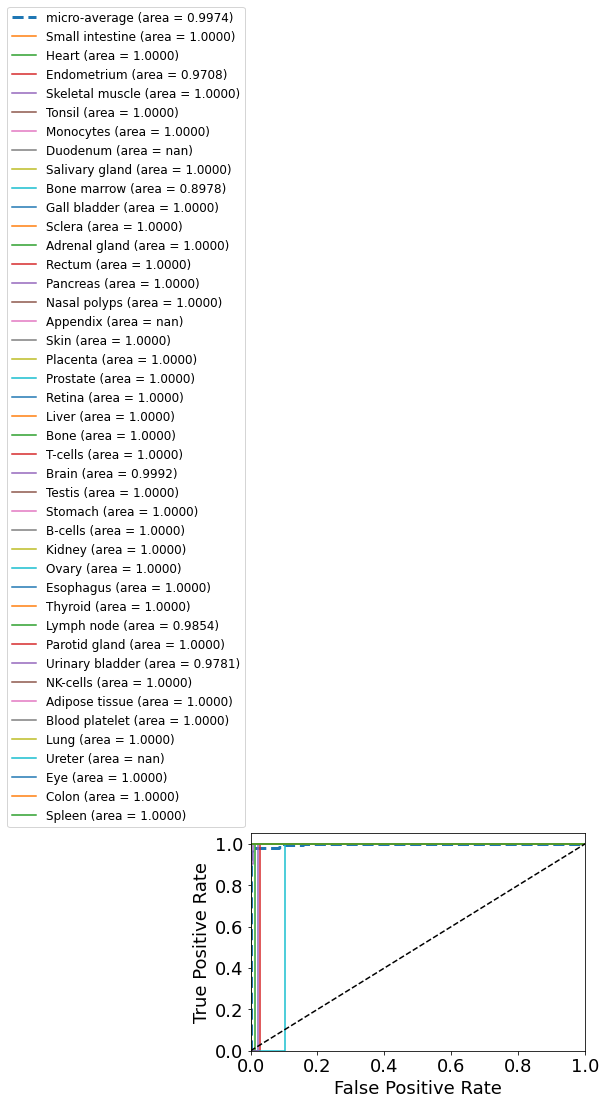

In [29]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc

rf_vs = OneVsRestClassifier(forest_opt)
classes =list(set(y['tissue_name'].to_list()))
y_bin = label_binarize(y, classes=classes)
X_train_vs, X_test_vs, y_train_vs, y_test_vs= train_test_split(X, y_bin, test_size=.20, random_state=0, stratify=y)
y_score_vs = rf_vs.fit(X_train_vs, y_train_vs).predict_proba(X_test_vs)


fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_vs[:,i], y_score_vs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_vs.ravel(), y_score_vs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
sns.reset_orig()
plt.clf()
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],'--', linewidth=3, label='micro-average (area = {0:0.4f})'
            ''.format(roc_auc["micro"]))
for i in range(num_classes):
    pos = classes[i]
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.4f})'
                ''.format(pos, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(bbox_to_anchor=(0,1), loc="lower right",fontsize=12)
#plt.gcf()



In [1]:
rf_vs = OneVsRestClassifier(forest_opt).fit(X_train, y_train)
feature_names = X.columns
classes = forest_opt.classes_   
for i in range(len(rf_vs.estimators_)): 
    pred_class = classes[i]
    print(pred_class)
    pred = rf_vs.estimators_[i]
    importances = pred.feature_importances_
    std = np.std([tree.feature_importances_ for tree in pred.estimators_], axis=0) #compute standard deviation of the feature importance over all the DecisionTreeClassifiers in the Random Forest
    
    rf_features_df = pd.DataFrame(columns=['feature_name', 'importance', 'standard deviation', 'abundance'])
    for f in range(X.shape[1]):
        rf_features_df.loc[f] = [feature_names[f], importances[f], std[f], X_train.iloc[:, f].values]
    values = (rf_features_df['importance'] != 0).sum()
    rf_features_df.to_csv('/home/compomics/git/Tissue_prediction/PTM_predictor/Output/Feature_importances_20240305_RF/{}.csv'.format(pred_class))
    print('{} contains {} not-zero features'.format(pred_class, values))


NameError: name 'OneVsRestClassifier' is not defined

In [45]:
X_train.columns

Index(['A0A075B6H7', 'A0A075B6H9', 'A0A075B6I0', 'A0A075B6I1', 'A0A075B6K5',
       'A0A075B6Q5', 'A0A075B6R2', 'A0A075B6S4', 'A0A075B6S5', 'A0A087WSY6',
       ...
       'Q9Y6V7', 'Q9Y6W3', 'Q9Y6W5', 'Q9Y6X0', 'Q9Y6X3', 'Q9Y6X5', 'Q9Y6X8',
       'Q9Y6X9', 'Q9Y6Y0', 'Q9Y6Y8'],
      dtype='object', length=6877)

# Feature reduction

Let's first have a look at the correlation between the features

In [35]:
X_train.head()

A0A075B6H7  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6K5  A0A075B6Q5  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   A0A075B6R2  A0A075B6S4  A0A075B6S5  A0A087WSY6  ...  Q9Y6V7  Q9Y6W3  \
0         0.0         0.0         0.0         0.0  ...     0.0     0.0   
1         0.0         0.0         0.0         0.0  ...     0.0     0.0   
2         0.0         0.0         0.0         0.0  ...     0.0     0.0   
3         0.0         0.0         0.0         0.0  ...     0.0     0.0   
4         0.0         0.0         0.0         0.0  ...     0.0     0.0   

   Q9Y6W5  Q9Y6X0  Q9Y6X3  Q9Y6X5  Q9Y6X8  Q9Y6X9  Q9Y6Y0  Q9Y6Y8  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 6877 columns]

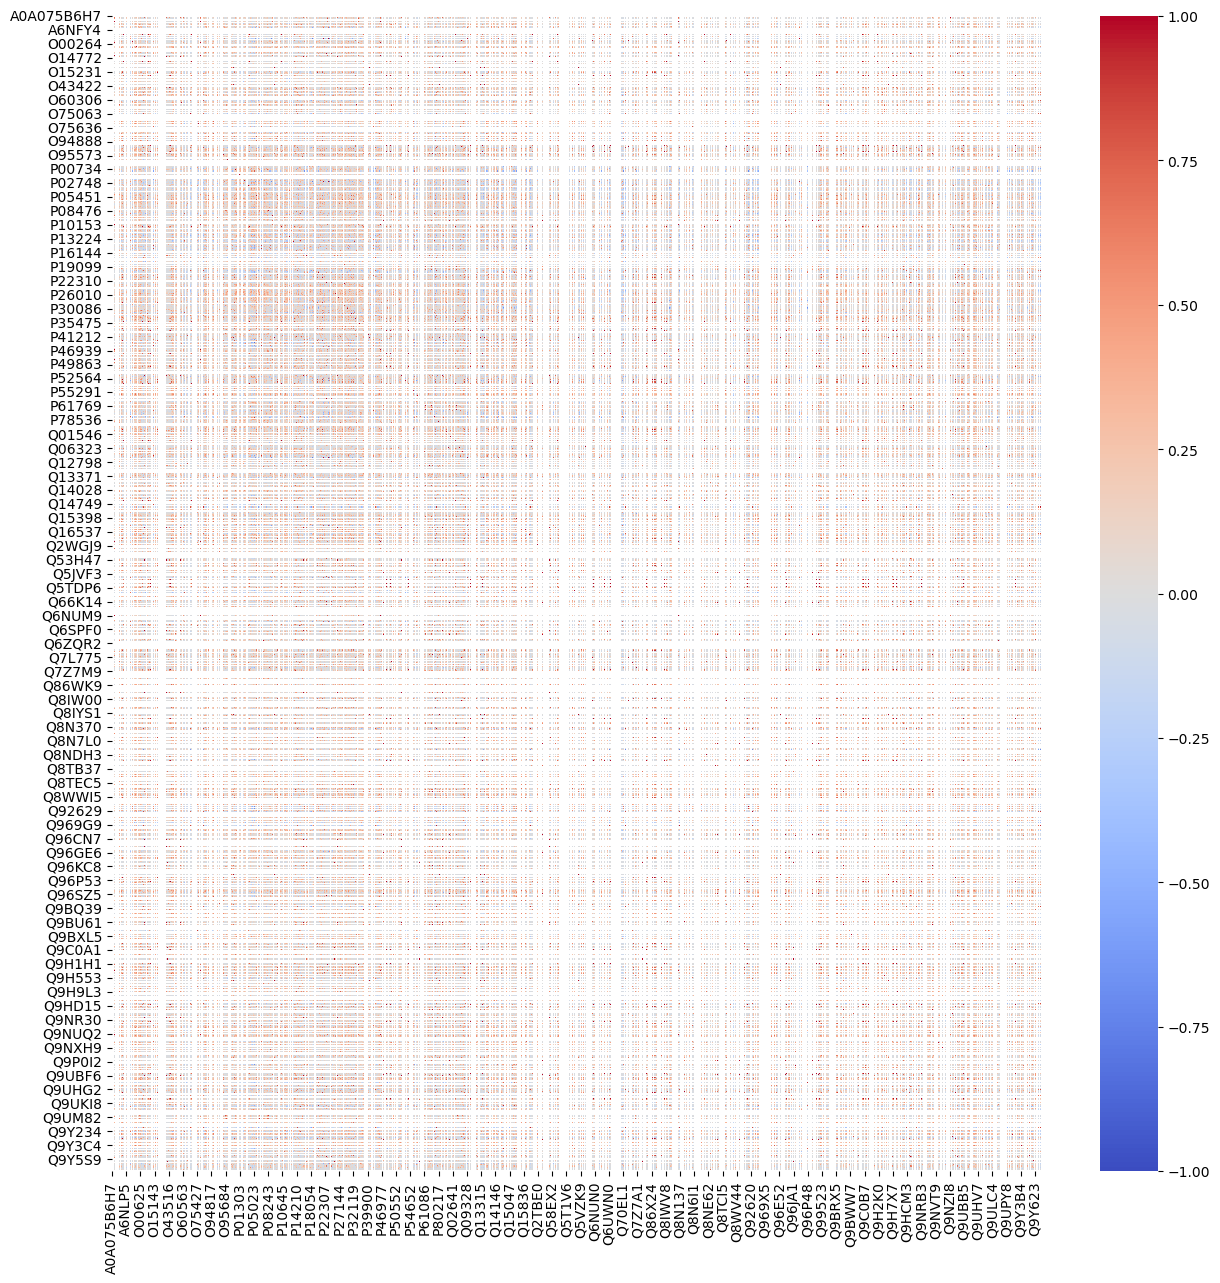

In [36]:
#correlation matrix of X
corr = X_train.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=False, fmt=".2f", cmap="coolwarm")
plt.show()

In [37]:
corr.head()

A0A075B6H7  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6K5  \
A0A075B6H7         1.0         NaN         NaN         NaN         NaN   
A0A075B6H9         NaN         NaN         NaN         NaN         NaN   
A0A075B6I0         NaN         NaN         NaN         NaN         NaN   
A0A075B6I1         NaN         NaN         NaN         NaN         NaN   
A0A075B6K5         NaN         NaN         NaN         NaN         NaN   

            A0A075B6Q5  A0A075B6R2  A0A075B6S4  A0A075B6S5  A0A087WSY6  ...  \
A0A075B6H7         NaN         NaN         NaN    0.252901         NaN  ...   
A0A075B6H9         NaN         NaN         NaN         NaN         NaN  ...   
A0A075B6I0         NaN         NaN         NaN         NaN         NaN  ...   
A0A075B6I1         NaN         NaN         NaN         NaN         NaN  ...   
A0A075B6K5         NaN         NaN         NaN         NaN         NaN  ...   

             Q9Y6V7    Q9Y6W3    Q9Y6W5  Q9Y6X0  Q9Y6X3    Q9Y6X5  Q9Y6X8  \
A0A075B6H7 -0.01495 -0.030152  0.041363     NaN     NaN -0.026039     NaN   
A0A075B6H9      NaN       NaN       NaN     NaN     NaN       NaN     NaN   
A0A075B6I0      NaN       NaN       NaN     NaN     NaN       NaN     NaN   
A0A075B6I1      NaN       NaN       NaN     NaN     NaN       NaN     NaN   
A0A075B6K5      NaN       NaN       NaN     NaN     NaN       NaN     NaN   

            Q9Y6X9  Q9Y6Y0    Q9Y6Y8  
A0A075B6H7     NaN     NaN -0.037772  
A0A075B6H9     NaN     NaN       NaN  
A0A075B6I0     NaN     NaN       NaN  
A0A075B6I1     NaN     NaN       NaN  
A0A075B6K5     NaN     NaN       NaN  

[5 rows x 6877 columns]

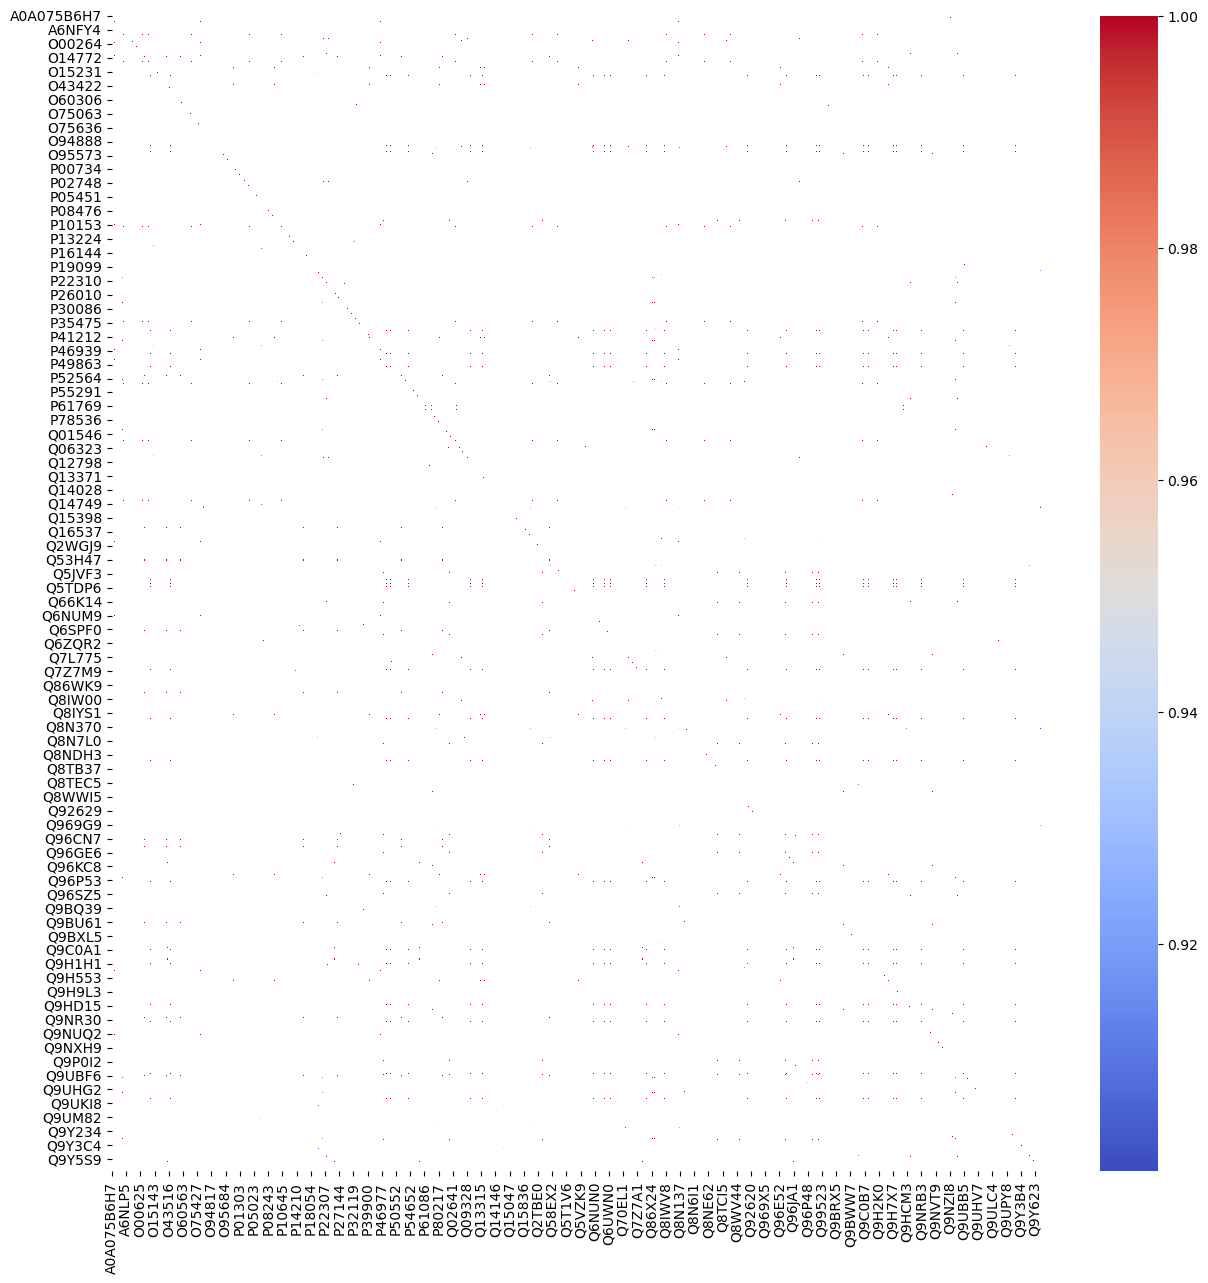

In [38]:
corr_0_9 = corr[corr > 0.9]
plt.figure(figsize=(15, 15))
sns.heatmap(corr_0_9, annot=False, fmt=".2f", cmap="coolwarm")
plt.show()

There are a lot of features with a correlation above 0.9 with another feature. Meaning that we can drop one of the two features.

Let's have a look at a PCA plot

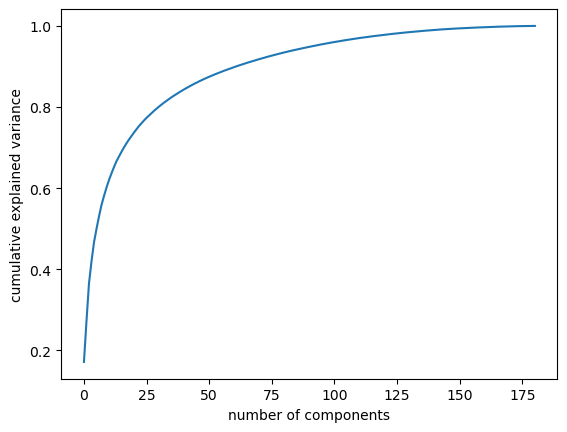

In [39]:
#make a PCA plot of the features and study the variance
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

pca.explained_variance_ratio_

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


Around a 100 PCA components explain 90% of the variance. This means that we can reduce the features a lot!

What ways of feature reduction can we use?
1. PCA
2. Feature selection
3. Feature importance
4. Feature correlation
5. Feature clustering
6. Feature extraction
7. Feature engineering


In [47]:
# define a function that takes X_train, y_train, X_test, y_test and returns a dataframe with the results
# it trains an xgboost model and validates it on the test set
def train_test_xgb(X_train, X_test, y_train, y_test, df, name):
    xgb= XGBClassifier(random_state=42, n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred =  xgb.predict(X_test)
    fm = f1_score(y_test, y_pred, average="macro")
    fw = f1_score(y_test, y_pred, average="weighted")
    acc = accuracy_score(y_test, y_pred)
    pw = precision_score(y_test, y_pred, average='weighted')
    pm = precision_score(y_test, y_pred, average='macro')
    rw = recall_score(y_test, y_pred, average='weighted')
    rm = recall_score(y_test, y_pred, average='macro')
    df_length = len(df)
    df.loc[df_length] = [name, acc, fm, pw, rm, fw, pm, rw]  
    return df

### PCA

In [48]:
#1 PCA
# Select features using PCA to get 95% of the variance
perc = 0.95
pca = PCA(n_components=perc) #0.95 means that we want to include 95% of the variance
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_PCA.shape)

#get column names of the selected features
selected_features_names = list(X_train.columns[pca.components_[0] != 0])
print(f"There were {len(selected_features_names)} features, combined in {X_train_PCA.shape[1]} components selected to address {perc*100}% of the variance")



NameError: name 'PCA' is not defined

In [ ]:
#use the selected features to train and test the model
result_df = train_test_xgb(X_train_PCA, X_test_PCA, y_train, y_test, result_df, 'XGB_PCA')
result_df

/home/compomics/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model  Accuracy  f1_macro  precision_macro  recall_macro  \
0   RandomForest_baseline  0.972973  0.889855         0.876812      0.913043   
1  RandomForest_optimised  0.986486  0.942029         0.934783      0.956522   
2                 XGB_PCA  0.864865  0.725274         0.861261      0.752899   

   f1_weighted  precision_weighted  recall_weighted  
0     0.963063            0.876812         0.972973  
1     0.981982            0.934783         0.986486  
2     0.852341            0.721739         0.864865

The F1 score drops dramatically using this approach so that is definitely not the best one to go with. 

### Feature selection

In [ ]:
#train baseline xgb
xgb= XGBClassifier(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)

#get feature importances
importances = xgb.feature_importances_

#feature selection based on feature importance
thresholds = np.sort(importances)

NameError: name 'XGBClassifier' is not defined

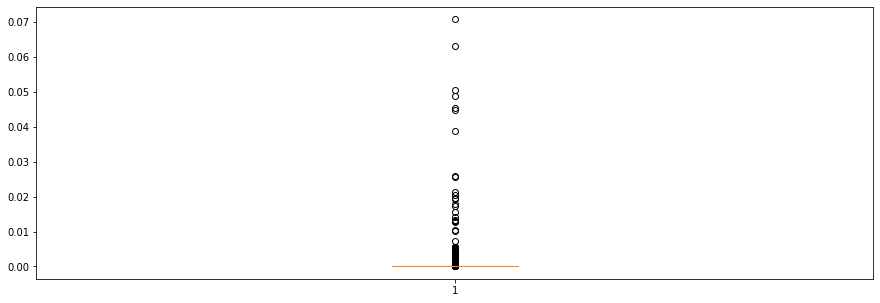

In [ ]:
#make a boxplot of thresholds
plt.figure(figsize=(15, 5))
plt.boxplot(thresholds)
plt.show()

In [ ]:
#Describe the thresholds, what is the cutoff for the quartiles?
#how many non zeroes are there in the feature importances?
print("Number of non-zero features: ", np.count_nonzero(importances))
#what is the smallest value in thresholds that is not zero?
print(f"The smallest value in thresholds that is not zero is {thresholds[thresholds != 0][0]}")

Number of non-zero features:  512
The smallest value in thresholds that is not zero is 6.932072210474871e-06


In [ ]:
#train an xgb with the non zero features
selection = SelectFromModel(xgb, threshold=0.0001, prefit=True)
select_X_train = selection.transform(X_train)

In [ ]:
smallest = thresholds[thresholds != 0][0]
selection = SelectFromModel(xgb, threshold=smallest, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(random_state=42, n_jobs=-1)
selection_model.fit(select_X_train, y_train)
print(f"The cutoff at {smallest} resulted in the selection of {select_X_train.shape[1]} features ")
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
fm = f1_score(y_test, y_pred, average="macro")
fw = f1_score(y_test, y_pred, average="weighted")
acc = accuracy_score(y_test, y_pred)
pw = precision_score(y_test, y_pred, average='weighted')
pm = precision_score(y_test, y_pred, average='macro')
rw = recall_score(y_test, y_pred, average='weighted')
rm = recall_score(y_test, y_pred, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = [f'XGB_feature_importance_smallest_nonzero{smallest}', acc, fm, pw, rm, fw, pm, rw]

/home/compomics/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:47:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The cutoff at 6.932072210474871e-06 resulted in the selection of 512 features 


/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
result_df

model  Accuracy  f1_macro  \
0                              RandomForest_baseline  0.961039  0.898549   
1                                       XGB_baseline  0.883117  0.723825   
2                             XGB_baseline_noweights  0.883117  0.723825   
3                                            XGB_PCA  0.850649  0.678607   
4  XGB_feature_importance_smallest_nonzero6.93207...  0.883117  0.723825   

   precision_macro  recall_macro  f1_weighted  precision_weighted  \
0         0.894669      0.912998     0.949976            0.894669   
1         0.709415      0.749633     0.854133            0.709415   
2         0.709415      0.749633     0.854133            0.709415   
3         0.827598      0.719916     0.829163            0.668350   
4         0.836514      0.749633     0.854133            0.709415   

   recall_weighted  
0         0.961039  
1         0.883117  
2         0.883117  
3         0.850649  
4         0.883117

So the XGB classifier actually only uses 515 features to achieve a classification with an f1 of 71%!
Let's see what happens to the correlation matrix if we only take those into account

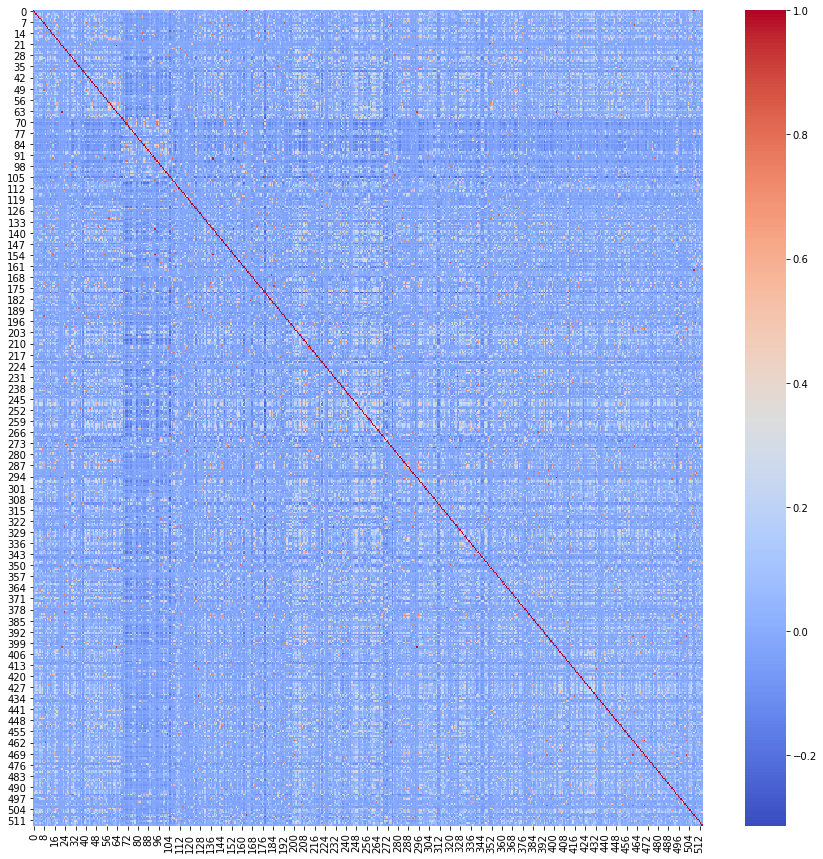

In [ ]:
#correlation matrix of X
corr_XGB_select = pd.DataFrame(select_X_train).corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_XGB_select, annot=False, fmt=".2f", cmap="coolwarm")
plt.show()

In general, the RF has a better F1 then the XGB so let's do the same for that. How many features have an importance above 0?

In [40]:
#train a baseline RandomForest_opt
forest_opt.fit(X_train, y_train)
baseline_predictions =  forest_opt.predict(X_test)
#print accuracy and f1 score
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
print("Accuracy: %.2f%%" % (acc * 100.0))
print("f1 macro: %.2f%%" % (fm * 100.0))
print("f1 weighted: %.2f%%" % (fw * 100.0))
#get the feature importances
importances = forest_opt.feature_importances_

#how many non zeroes are there in the feature importances?
print("Number of non-zero features: ", np.count_nonzero(importances))
#what is the smallest value in thresholds that is not zero?
print(f"The smallest value in thresholds that is not zero is {importances[importances != 0][0]}")

Accuracy: 97.92%
f1 macro: 98.02%
f1 weighted: 98.12%
Number of non-zero features:  1273
The smallest value in thresholds that is not zero is 0.0017873817986209998


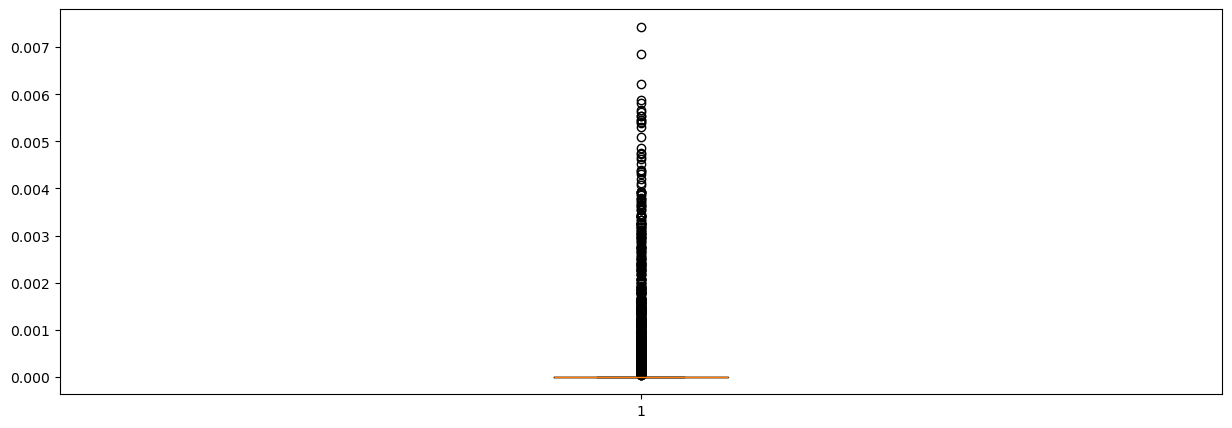

In [41]:
#Now we will use the feature importances to select features
# Select features using threshold
thresholds = np.sort(importances)
#make a boxplot of thresholds
plt.figure(figsize=(15, 5))
plt.boxplot(thresholds)
plt.show()

In [42]:
#SElect the highest 10% of thresholds, what value is the cutoff?
perc = 0.1

In [43]:
# Going over the highest 10%, 20%, 30% etc. of the features
# Train and evaluate a RandomForest
plot_df = pd.DataFrame(columns=['Percentage', 'Features', 'f1_macro', 'f1_weighted', 'accuracy'])
for perc in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1,0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 1]: #highest 10%, 20%
    smallest = thresholds[int(len(thresholds)*(1-perc))]
    print(f"The cutoff at {smallest} resulted in the selection of {len(thresholds[thresholds > smallest])} features ")
    selection = SelectFromModel(forest_opt, threshold=smallest, prefit=True)
    select_X_train = selection.transform(X_train)
    print(f"Threshold {perc} resulted in {select_X_train.shape[1]} features")
    # train model
    selection_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    fm = f1_score(y_test, y_pred, average="macro")
    fw = f1_score(y_test, y_pred, average="weighted")
    acc = accuracy_score(y_test, y_pred)
    pw = precision_score(y_test, y_pred, average='weighted')
    pm = precision_score(y_test, y_pred, average='macro')
    rw = recall_score(y_test, y_pred, average='weighted')
    rm = recall_score(y_test, y_pred, average='macro')
    df_length = len(result_df)
    result_df.loc[df_length] = [f'RandomForest_feature_importance_{perc}', acc, fm, pw, rm, fw, pm, rw]
    plot_df.loc[len(plot_df)] = [perc, select_X_train.shape[1], fm, fw, acc]

The cutoff at 0.0031246605699437957 resulted in the selection of 68 features 


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold 0.01 resulted in 69 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0019840788026568765 resulted in the selection of 137 features 
Threshold 0.02 resulted in 138 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


The cutoff at 0.0014234086823935817 resulted in the selection of 206 features 


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold 0.03 resulted in 207 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0010249508703608703 resulted in the selection of 275 features 
Threshold 0.04 resulted in 276 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


The cutoff at 0.0008433462477211824 resulted in the selection of 343 features 


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold 0.05 resulted in 344 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


The cutoff at 0.000301259147380588 resulted in the selection of 687 features 


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold 0.1 resulted in 688 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


The cutoff at 0.0 resulted in the selection of 1273 features 


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold 0.2 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 1273 features 
Threshold 0.25 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 1273 features 
Threshold 0.3 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 1273 features 
Threshold 0.35 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 1273 features 
Threshold 0.4 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 1273 features 
Threshold 0.45 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 1273 features 
Threshold 0.5 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 1273 features 
Threshold 0.75 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 1273 features 
Threshold 1 resulted in 6877 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
plot_df

Percentage  Features  f1_macro  f1_weighted  accuracy
0         0.01      69.0  0.896825     0.942460  0.958333
1         0.02     138.0  1.000000     1.000000  1.000000
2         0.03     207.0  0.924603     0.953373  0.958333
3         0.04     276.0  0.980159     0.981151  0.979167
4         0.05     344.0  1.000000     1.000000  1.000000
5         0.10     688.0  1.000000     1.000000  1.000000
6         0.20    6877.0  0.944444     0.972222  0.979167
7         0.25    6877.0  0.944444     0.972222  0.979167
8         0.30    6877.0  0.944444     0.972222  0.979167
9         0.35    6877.0  0.944444     0.972222  0.979167
10        0.40    6877.0  0.944444     0.972222  0.979167
11        0.45    6877.0  0.944444     0.972222  0.979167
12        0.50    6877.0  0.944444     0.972222  0.979167
13        0.75    6877.0  0.944444     0.972222  0.979167
14        1.00    6877.0  0.944444     0.972222  0.979167

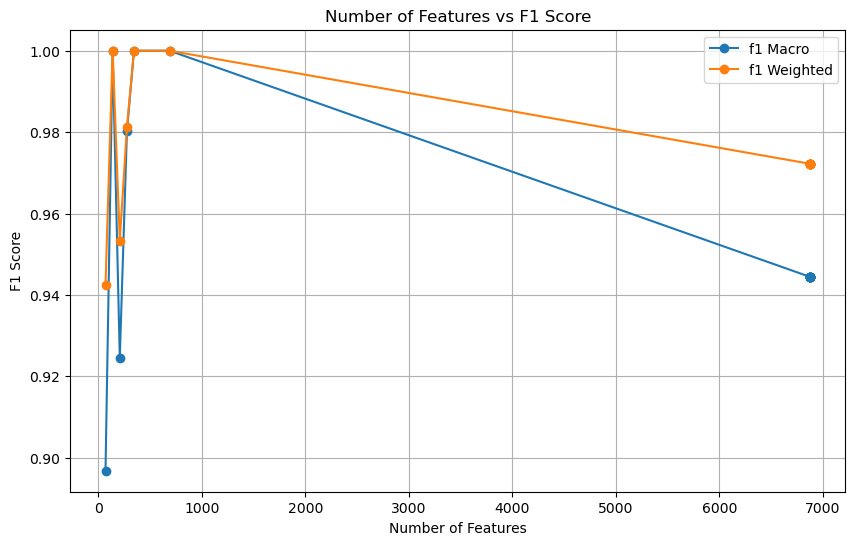

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(plot_df['Features'], plot_df['f1_macro'], marker='o', label='f1 Macro')
plt.plot(plot_df['Features'], plot_df['f1_weighted'], marker='o', label='f1 Weighted')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('Number of Features vs F1 Score')
plt.legend()
plt.grid(True)
plt.show()

Highest performance is with the top 10% of the features 688.0 features, 0.955556 f1n macro,0.983007 f1 weighted	0.988235 accuracy

In [55]:
#Just do the 4% RF
perc=0.1
smallest = thresholds[int(len(thresholds)*(1-perc))]
print(f"The cutoff at {smallest} resulted in the selection of {len(thresholds[thresholds > smallest])} features ")
selection = SelectFromModel(forest, threshold=smallest, prefit=True)
select_X_train_RF = selection.transform(X_train)
print(f"Threshold {perc} resulted in {select_X_train_RF.shape[1]} features")
# train model
selection_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
selection_model.fit(select_X_train_RF, y_train)
# eval model
select_X_test_RF = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test_RF)
fm = f1_score(y_test, y_pred, average="macro")
fw = f1_score(y_test, y_pred, average="weighted")
acc = accuracy_score(y_test, y_pred)
pw = precision_score(y_test, y_pred, average='weighted')
pm = precision_score(y_test, y_pred, average='macro')
rw = recall_score(y_test, y_pred, average='weighted')
rm = recall_score(y_test, y_pred, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = [f'RandomForest_feature_importance_{perc}', acc, fm, pw, rm, fw, pm, rw]

The cutoff at 0.000301259147380588 resulted in the selection of 687 features 
Threshold 0.1 resulted in 1125 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [56]:
selected_feature_names = X_train.columns[selection.get_support()]
print(selected_feature_names)

Index(['A0A075B6H7', 'A0A0C4DH34', 'A0A0C4DH38', 'A1L4H1', 'A1L4K1', 'A1X283',
       'A5A3E0', 'A6NGN9', 'A6NHZ5', 'A6NNZ2',
       ...
       'Q9Y696', 'Q9Y6A4', 'Q9Y6I3', 'Q9Y6L6', 'Q9Y6N5', 'Q9Y6N6', 'Q9Y6Q1',
       'Q9Y6R1', 'Q9Y6R7', 'Q9Y6V0'],
      dtype='object', length=1125)


In [57]:
from joblib import dump

# Specify the file path where you want to save the joblib file
file_path = '/home/compomics/git/MLMarker/models/binary_RF_minimalfeatureset_20241001.joblib'
dump(selection_model, file_path)

np.savetxt('/home/compomics/git/MLMarker/models/binary_features_RF_minimalfeatureset_20241001.txt', selected_feature_names, fmt='%s,')


In [53]:
rf_vs =  OneVsRestClassifier(selection_model).fit(select_X_train_RF, y_train)
feature_names = X.columns
classes = selection_model.classes_   
for i in range(len(rf_vs.estimators_)): 
    pred_class = classes[i]
    print(pred_class)
    pred = rf_vs.estimators_[i]
    importances = pred.feature_importances_
    std = np.std([tree.feature_importances_ for tree in pred.estimators_],axis=0) #compute standard deviation of the feature importance over all the DecisionTreeClassifiers in the Random Forest
    
    rf_features_df = pd.DataFrame(columns=['feature_name', 'importance', 'standard deviation'])
    for f in range(select_X_train_RF.shape[1]):
        rf_features_df.loc[f] = [feature_names[f], importances[f], std[f]]
    values = (rf_features_df['importance'] != 0).sum()
    rf_features_df.to_csv('/home/compomics/git/Tissue_prediction/PTM_predictor/Output/Feature_importances_minimalfeatureset_tissueclassification_20240219/{}.csv'.format(pred_class))
    print('{} contains {} not-zero features'.format(pred_class, values))


Adrenal gland
Adrenal gland contains 207 not-zero features
B-cells
B-cells contains 263 not-zero features
Bone
Bone contains 186 not-zero features
Brain
Brain contains 249 not-zero features
Colon
Colon contains 248 not-zero features
Esophagus
Esophagus contains 194 not-zero features
Gall bladder
Gall bladder contains 215 not-zero features
Heart
Heart contains 245 not-zero features
Kidney
Kidney contains 254 not-zero features
Liver
Liver contains 222 not-zero features
Lung
Lung contains 251 not-zero features
Monocytes
Monocytes contains 178 not-zero features
NK-cells
NK-cells contains 179 not-zero features
Nasal polyps
Nasal polyps contains 180 not-zero features
Ovary
Ovary contains 401 not-zero features
Pancreas
Pancreas contains 217 not-zero features
Parotid gland
Parotid gland contains 170 not-zero features
Placenta
Placenta contains 207 not-zero features
Prostate
Prostate contains 184 not-zero features
Skeletal muscle
Skeletal muscle contains 194 not-zero features
Small intestine
Sm

In [41]:
result_df

model  Accuracy  f1_macro  precision_macro  \
0                  RandomForest_baseline  0.976471  0.908364         0.900000   
1   RandomForest_feature_importance_0.01  0.952941  0.838667         0.934174   
2   RandomForest_feature_importance_0.02  0.976471  0.902222         0.961176   
3   RandomForest_feature_importance_0.03  0.976471  0.912000         0.960784   
4   RandomForest_feature_importance_0.04  0.976471  0.912727         0.956863   
5   RandomForest_feature_importance_0.05  0.976471  0.912000         0.960784   
6    RandomForest_feature_importance_0.1  0.988235  0.955556         0.978824   
7    RandomForest_feature_importance_0.2  0.988235  0.955556         0.978824   
8   RandomForest_feature_importance_0.25  0.988235  0.955556         0.978824   
9    RandomForest_feature_importance_0.3  0.976471  0.908364         0.958824   
10  RandomForest_feature_importance_0.35  0.976471  0.908364         0.958824   
11   RandomForest_feature_importance_0.4  0.976471  0.908364         0.958824   
12  RandomForest_feature_importance_0.45  0.976471  0.908364         0.958824   
13   RandomForest_feature_importance_0.5  0.976471  0.908364         0.958824   
14  RandomForest_feature_importance_0.75  0.976471  0.908364         0.958824   
15     RandomForest_feature_importance_1  0.976471  0.908364         0.958824   
16   RandomForest_feature_importance_0.1  0.988235  0.955556         0.978824   

    recall_macro  f1_weighted  precision_weighted  recall_weighted  
0           0.92     0.966417            0.900000         0.976471  
1           0.86     0.938431            0.835238         0.952941  
2           0.92     0.967320            0.892000         0.976471  
3           0.92     0.967059            0.906667         0.976471  
4           0.92     0.965775            0.906667         0.976471  
5           0.92     0.967059            0.906667         0.976471  
6           0.96     0.983007            0.952000         0.988235  
7           0.96     0.983007            0.952000         0.988235  
8           0.96     0.983007            0.952000         0.988235  
9           0.92     0.966417            0.900000         0.976471  
10          0.92     0.966417            0.900000         0.976471  
11          0.92     0.966417            0.900000         0.976471  
12          0.92     0.966417            0.900000         0.976471  
13          0.92     0.966417            0.900000         0.976471  
14          0.92     0.966417            0.900000         0.976471  
15          0.92     0.966417            0.900000         0.976471  
16          0.96     0.983007            0.952000         0.988235

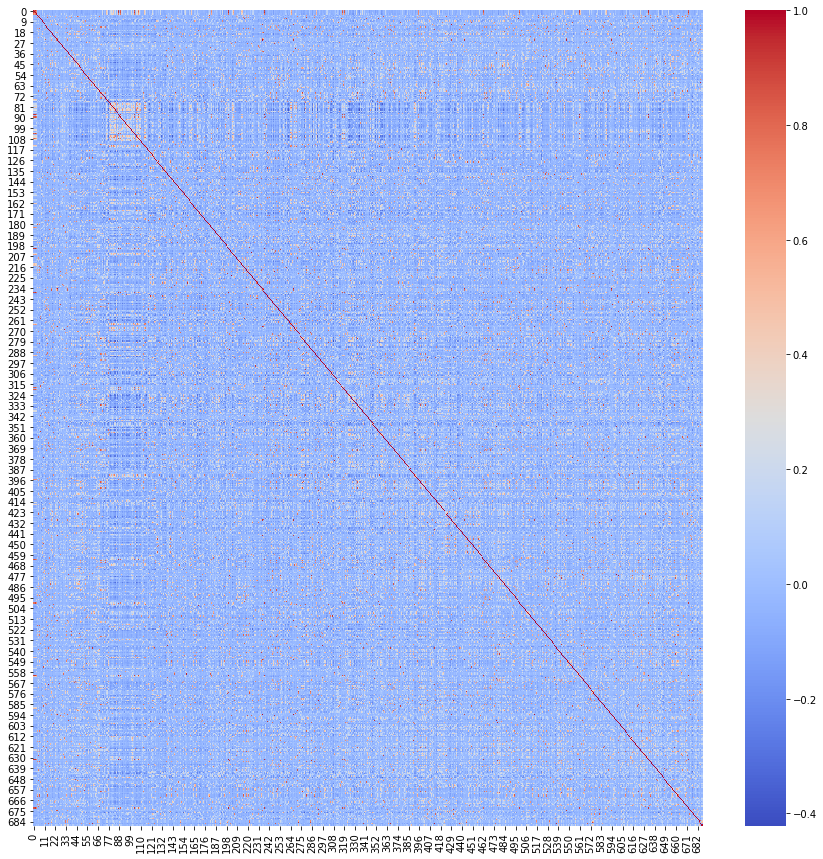

In [42]:
#correlation matrix of subset of RF features
corr_RF_select = pd.DataFrame(select_X_train_RF).corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_RF_select, annot=False, fmt=".2f", cmap="coolwarm")
plt.show()

RF is better compared to XGB but has more highly correlating features so there might be some redundancy there. Although 688 features is not bad! Let's dig deeper in to them

In [50]:
import pandas as pd

# Set the display option to print without truncation
pd.set_option('display.max_colwidth', None)

selected_features = X_train.columns[selection.get_support()]
for feature in selected_features:
    print(feature)


A0A075B6I0
A0A0C4DH29
A0A0C4DH31
A0A0C4DH38
A5A3E0
A6NHL2
A6NHZ5
A8K2U0
O00151
O00160
O00264
O00468
O14494
O14594
O14975
O14983
O15020
O15061
O15117
O15127
O15143
O15335
O15460
O15498
O43581
O43692
O43707
O43813
O43895
O60218
O60240
O60343
O60565
O60568
O60662
O60829
O60844
O60869
O75083
O75112
O75339
O75380
O75427
O75438
O75533
O75582
O75791
O75792
O75874
O75891
O75915
O75937
O76031
O76041
O94804
O94819
O94925
O95169
O95197
O95274
O95425
O95674
O95810
O95816
O95817
O95831
O95833
O95865
O95881
O95954
P00326
P00338
P00352
P00403
P00480
P00488
P00491
P00505
P00742
P00747
P01008
P01009
P01019
P01023
P01024
P01034
P01042
P01275
P01599
P01619
P01700
P01833
P01871
P02042
P02452
P02533
P02549
P02675
P02730
P02743
P02748
P02749
P02760
P02763
P02765
P02775
P02787
P02790
P03973
P04003
P04004
P04066
P04080
P04179
P04196
P04217
P04275
P04279
P04350
P04406
P04746
P04792
P04843
P04844
P05023
P05026
P05091
P05109
P05120
P05164
P05186
P05386
P05387
P05451
P05556
P05783
P05787
P05976
P06127
P06396
P065

In [43]:
#get the feature names 
selected_features_names = list(X_train.columns[selection.get_support()])
print(len(selected_features_names))

688


In [52]:
#save the selected feature names as a txt
with open('/home/compomics/git/Tissue_prediction/PTM_predictor/Output/minimal_features_names.txt', 'w') as f:
    for item in selected_features_names:
        f.write("%s\n" % item)

In [44]:
#Can we get a SHAP value per feature, per class
import shap
shap.initjs()
explainer = shap.TreeExplainer(selection_model)
shap_values = explainer.shap_values(select_X_train_RF)

In [94]:
proteinData = pd.read_csv('./Atlases/filtered_data_50%_peptidoform_allmodifications_relevant_20231023.csv', sep=',')
proteinData = proteinData[proteinData['uniprot_id'].isin(selected_features_names)]
proteinData = proteinData[proteinData['tissue_name'].isin(np.unique(y['tissue_name'].values))]
proteinData['modified_protein'] = proteinData['uniprot_id'] + '_' + proteinData['mod_id'].astype(str)
proteinData.head()

assay_id  peptidoform_id  quantification  tissue_id tissue_name  cell_type  \
0     24268          323332             2.0      645.0   Esophagus  Esophagus   
1     24270          323332             5.0      645.0   Esophagus  Esophagus   
2     28870          323332             2.0      721.0      Tonsil     Tonsil   
3     24270         7493883             9.0      645.0   Esophagus  Esophagus   
6     24266           96468            10.0      644.0       Colon      Colon   

  disease_status uniprot_id  mod_id modified_protein Description  \
0        Healthy     A8K2U0       0         A8K2U0_0  Unmodified   
1        Healthy     A8K2U0       0         A8K2U0_0  Unmodified   
2        Healthy     A8K2U0       0         A8K2U0_0  Unmodified   
3        Healthy     A8K2U0       0         A8K2U0_0  Unmodified   
6        Healthy     P01833       0         P01833_0  Unmodified   

   Monoisotopic mass  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
6                0.0

In [95]:
#replace all the quantification values with 1
proteinData['quantification'] = 1
#pivot table
assay_atlas = pd.pivot_table(proteinData, values='quantification', index=['tissue_name'], columns='modified_protein')
assay_atlas.head()

modified_protein  A0A075B6I0_0  A0A0B4J1U7_0  A5A3E0_0  A5A3E0_35  A8K2U0_0  \
tissue_name                                                                   
Adipose tissue             NaN           1.0       NaN        NaN       NaN   
Adrenal gland              NaN           1.0       NaN        NaN       NaN   
Appendix                   NaN           NaN       1.0        1.0       NaN   
B-cells                    NaN           NaN       NaN        NaN       NaN   
Blood platelet             NaN           NaN       NaN        NaN       NaN   

modified_protein  O00151_0  O00151_122  O00151_35  O00151_401  O00264_0  ...  \
tissue_name                                                              ...   
Adipose tissue         1.0         NaN        NaN         NaN       1.0  ...   
Adrenal gland          1.0         NaN        NaN         NaN       1.0  ...   
Appendix               1.0         NaN        NaN         NaN       1.0  ...   
B-cells                1.0         NaN        NaN         NaN       NaN  ...   
Blood platelet         1.0         NaN        1.0         NaN       NaN  ...   

modified_protein  Q9Y678_7  Q9Y6C2_0  Q9Y6C2_122  Q9Y6C2_35  Q9Y6C2_43  \
tissue_name                                                              
Adipose tissue         NaN       1.0         NaN        NaN        NaN   
Adrenal gland          NaN       1.0         NaN        NaN        NaN   
Appendix               NaN       1.0         NaN        NaN        1.0   
B-cells                NaN       1.0         NaN        NaN        NaN   
Blood platelet         NaN       1.0         NaN        NaN        NaN   

modified_protein  Q9Y6C2_5  Q9Y6C2_7  Q9Y6Q1_0  Q9Y6Q1_35  Q9Y6Q1_5  
tissue_name                                                          
Adipose tissue         NaN       1.0       NaN        NaN       NaN  
Adrenal gland          NaN       1.0       NaN        NaN       NaN  
Appendix               NaN       1.0       NaN        NaN       NaN  
B-cells                NaN       NaN       NaN        NaN       NaN  
Blood platelet         NaN       NaN       NaN        NaN       NaN  

[5 rows x 1222 columns]

In [96]:
assay_atlas.shape

(41, 1222)

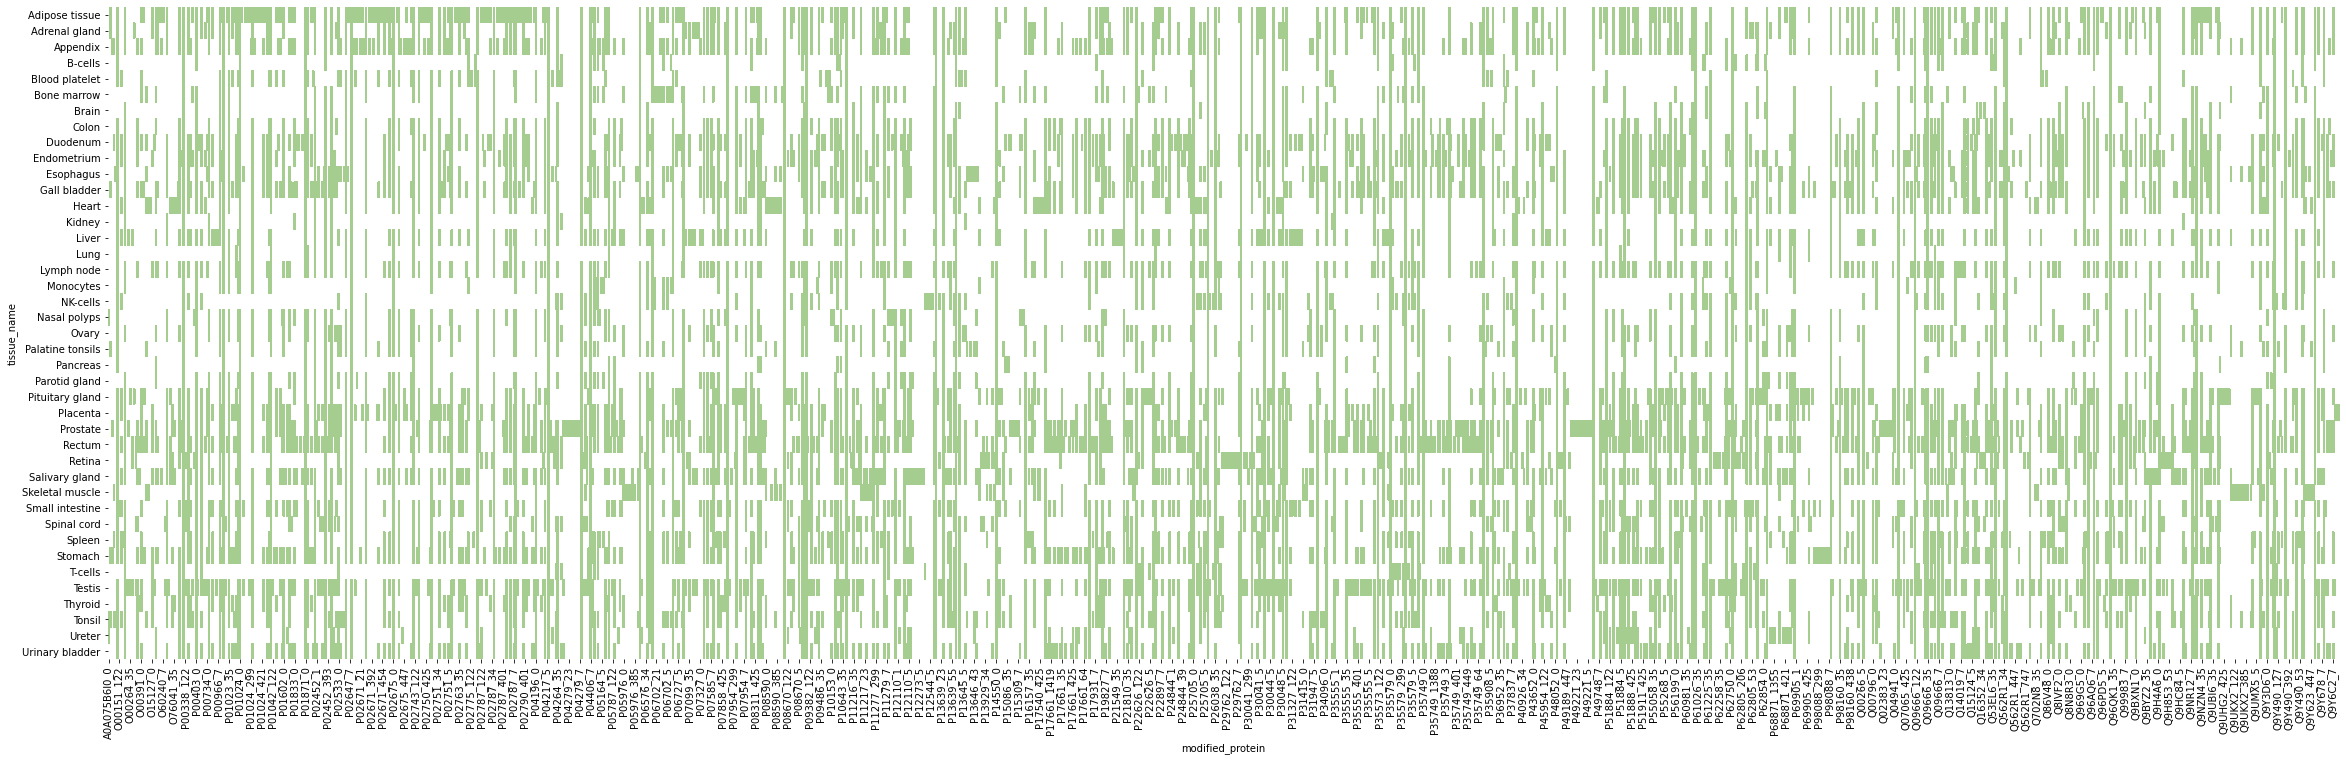

In [97]:
#make a heatmap of the pivot table
plt.figure(figsize=(40, 12))
#remove the colour bar on the right
#make the colours dark orange
sns.heatmap(assay_atlas, annot=False, fmt=".2f", cbar=False, cmap="crest")
plt.show()

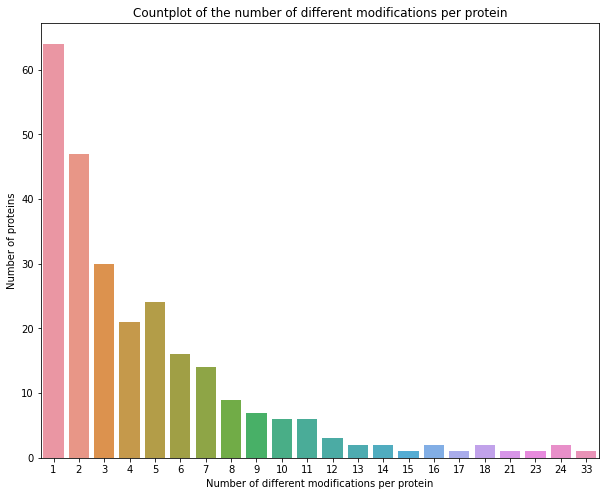

In [126]:
#get filtered_mod_binary and count per protein the different mod_ids
mod_per_protein = proteinData.groupby('uniprot_id')['mod_id'].nunique().reset_index(name='counts')
#summarize in a countplot
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x='counts', data=mod_per_protein, ax=ax)
#add title
plt.title('Countplot of the number of different modifications per protein')
#set y-axis from 0 to 250
#plt.ylim(0,250)
#set x-axis
plt.xlabel('Number of different modifications per protein')
plt.ylabel('Number of proteins')
plt.show()


### Study the difference in modifications per protein in the subset versus the entire dataframe

In [127]:
mod_per_protein.to_csv('./Atlases/mod_per_protein_TPsubset.csv', index=False)

In [128]:
entire_mod_per_protein = pd.read_csv('./Atlases/mod_per_protein_all.csv')

In [129]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

Number of significant comparisons (out of 1000): 1000


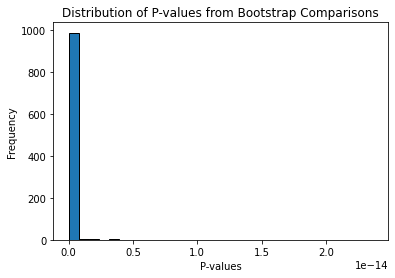

In [130]:
# Number of bootstrap iterations
n_iterations = 1000
p_values = []

for _ in range(n_iterations):
    # Draw a random sample from entire_mod_per_protein of the same size as mod_per_protein
    bootstrap_sample = entire_mod_per_protein.sample(n=len(mod_per_protein), replace=False)
    
    # Perform the Mann-Whitney U test between the bootstrap sample and mod_per_protein
    _, p_value = mannwhitneyu(bootstrap_sample['counts'], mod_per_protein['counts'])
    p_values.append(p_value)

# Analyzing the distribution of p-values
alpha = 0.05
significant_comparisons = sum(1 for p in p_values if p < alpha)

print(f"Number of significant comparisons (out of {n_iterations}): {significant_comparisons}")

# Optional: Plotting the distribution of p-values
import matplotlib.pyplot as plt
plt.hist(p_values, bins=30, edgecolor='k')
plt.xlabel('P-values')
plt.ylabel('Frequency')
plt.title('Distribution of P-values from Bootstrap Comparisons')
plt.show()

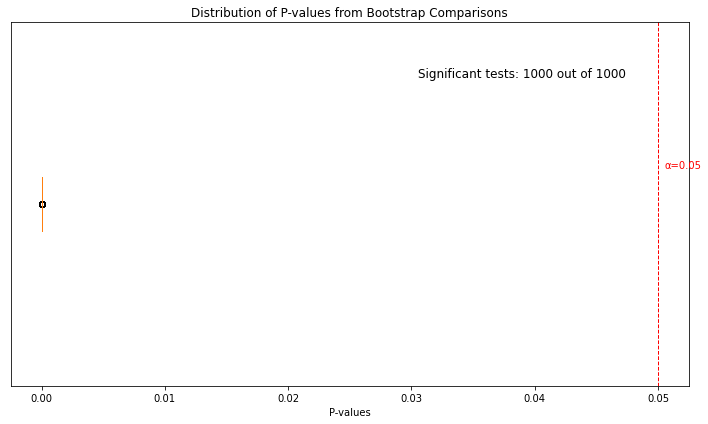

In [131]:
import matplotlib.pyplot as plt

# Plotting the distribution of p-values using a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(p_values, vert=False)
plt.axvline(x=alpha, color='red', linestyle='dashed', linewidth=1)
plt.text(alpha+0.0005, 1.1, 'α=0.05', color='red')

# Annotating with the number of significant tests
plt.annotate(f"Significant tests: {significant_comparisons} out of {n_iterations}",
             xy=(0.6, 0.85), xycoords='axes fraction', fontsize=12)

plt.xlabel('P-values')
plt.yticks([])  # Remove y-axis ticks as they're not needed for a single boxplot
plt.title('Distribution of P-values from Bootstrap Comparisons')
plt.tight_layout()
plt.show()


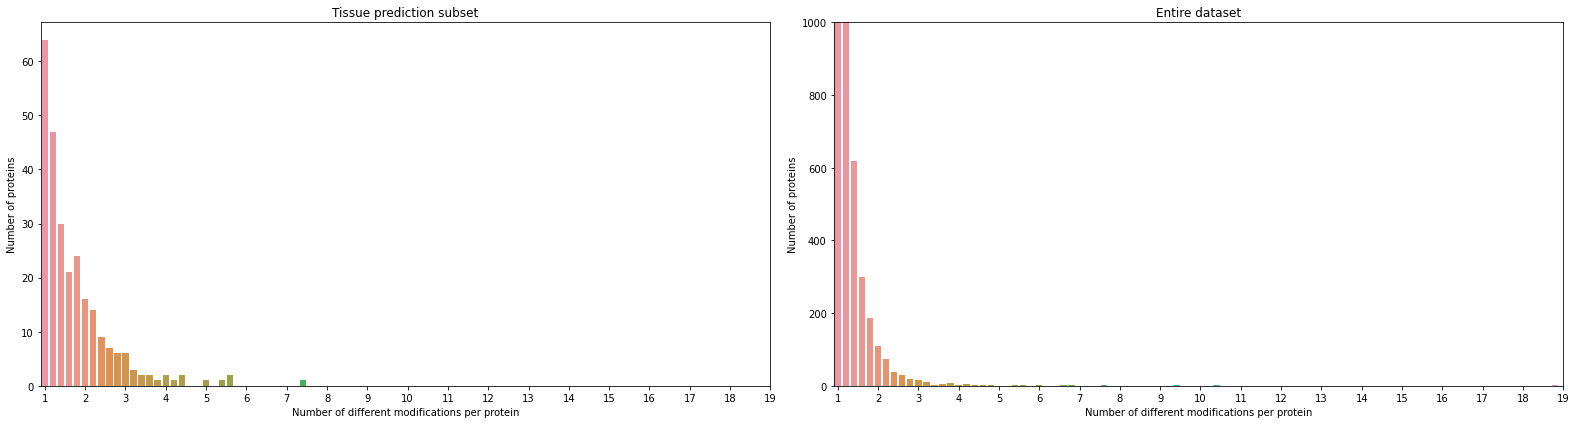

In [132]:


# Determine the maximum value across both dataframes
max_value = max(mod_per_protein['counts'].max(), entire_mod_per_protein['counts'].max())

# Plotting the distributions using countplots
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='counts', data=mod_per_protein, order=range(1, max_value + 1))
plt.title("Tissue prediction subset")
#add x-ticks every 5
plt.xticks(np.arange(0, max_value + 1, 5.0))
#set x-axis
plt.xlabel('Number of different modifications per protein')
plt.ylabel('Number of proteins')

plt.subplot(1, 2, 2)
sns.countplot(x='counts', data=entire_mod_per_protein, order=range(1, max_value + 1))
plt.title("Entire dataset")
#add x-ticks every 5
plt.xticks(np.arange(0, max_value + 1, 5.0))
#set y-axis maximum
plt.ylim(0,1000)
#set x-axis
plt.xlabel('Number of different modifications per protein')
plt.ylabel('Number of proteins')

plt.tight_layout()
plt.show()

In [47]:
import random
def sampleData(DataFrame, ratio):
    df_size = len(DataFrame.index)
    sample_size = int(round(ratio * df_size))
    if sample_size == df_size:
        sample_size = sample_size - 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    elif sample_size == 0:
        sample_size = 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    else:
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

In [48]:
def split_data_balanced(df, split_perc):
    """Splits data into train and test sets, ensuring that each tissue is represented in both sets. 
    Input a split_percentage between 0 and 1 to determine the proportion of data to be used for training."""
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    tissues = df['tissue_name'].unique()
    DataFrameDict = {elem : pd.DataFrame for elem in tissues}
    for key in DataFrameDict.keys():
        DataFrameDict[key] = df[:][df['tissue_name'] == key]

    for key in DataFrameDict.keys():
        train = sampleData(DataFrameDict[key], split_perc)
        train_df = train_df.append(train)

        test = DataFrameDict[key].drop(train.index)
        test_df = test_df.append(test)

    y_train = train_df.pop('tissue_name').values
    X_train = train_df.values
    y_test = test_df.pop('tissue_name').values
    X_test = test_df.values

    X_train = pd.DataFrame(X_train, columns=(df.columns)[:-1])
    X_test = pd.DataFrame(X_test, columns=(df.columns)[:-1])
    return X_train, y_train, X_test, y_test

In [49]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, result_df):
    """Provide a model, model name, and data to train and test on. Returns a dataframe with the model name and evaluation metrics. 
    Evaluation metrics include: Accuracy, f1_macro, precision_macro, recall_macro, f1_weighted, precision_weighted, recall_weighted"""
    if result_df is None:
        result_df = pd.DataFrame(columns=['model','Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fm = f1_score(y_test, predictions, average="macro")
    fw = f1_score(y_test, predictions, average="weighted")
    acc = accuracy_score(y_test, predictions)
    pw = precision_score(y_test, predictions, average='weighted', zero_division=1)
    pm = precision_score(y_test, predictions, average='macro', zero_division=1)
    rw = recall_score(y_test, predictions, average='weighted')
    rm = recall_score(y_test, predictions, average='macro')
    df_length = len(result_df)
    result_df.loc[df_length] = [model_name, acc, fm, pm, rm, fw, pm, rw]
    return result_df

In [64]:
def preprocess_data(df):
    """Preprocessing function that removes fluid samples, underrepresented tissues and removes cell type and disease status column"""
    #drop fluid tissues
    fluids=['Blood', 'Blood platelets','Cerebrospinal fluid', 'Urine', 'Follicular fluid', 'Sputum']
    df = df[~df['tissue_name'].isin(fluids)]
    #drop tissues with only 1 assay present
    df = df.groupby('tissue_name').filter(lambda x: len(x) > 1)
    #drop cell_type and disease_status
    #df = df.drop(['cell_type', 'disease_status'], axis=1)
    return df

In [71]:
assay_atlas2 = preprocess_data(assay_atlas)

In [66]:
#split data into train and test sets, with every tissue represented in both sets
X_train, y_train, X_test, y_test = split_data_balanced(assay_atlas, 0.8)

In [68]:
assay_atlas2.reset_index(inplace=True)
assay_atlas2.head()

Empty DataFrame
Columns: [index, tissue_name, A0A075B6I0_0, A0A075B6I0_1, A0A0B4J1U7_0, A0A0B4J1U7_122, A0A0B4J1U7_34, A0A0B4J1U7_35, A0A0B4J1U7_425, A5A3E0_0, A5A3E0_1249, A5A3E0_1375, A5A3E0_1428, A5A3E0_1434, A5A3E0_35, A5A3E0_447, A5A3E0_5, A5A3E0_793, A5A3E0_898, A5A3E0_959, A8K2U0_0, A8K2U0_122, A8K2U0_35, O00151_0, O00151_1, O00151_122, O00151_299, O00151_312, O00151_35, O00151_374, O00151_382, O00151_40, O00151_401, O00151_414, O00151_425, O00151_5, O00151_53, O00151_55, O00151_7, O00264_0, O00264_1, O00264_122, O00264_1419, O00264_1434, O00264_1843, O00264_21, O00264_23, O00264_34, O00264_35, O00264_40, O00264_450, O00264_5, O00264_7, O00339_0, O00339_35, O00391_0, O00391_122, O00391_34, O00391_35, O00391_425, O00391_5, O00391_7, O14958_0, O14958_1, O14958_122, O14958_299, O14958_34, O14958_35, O14958_425, O14958_5, O14958_53, O14958_7, O14958_947, O15127_0, O15127_122, O15127_7, O43813_0, O43813_122, O43813_36, O43813_5, O60240_0, O60240_1, O60240_122, O60240_127, O60240_21, O60240_299, O60240_34, O60240_35, O60240_40, O60240_425, O60240_5, O60240_7, O60282_0, O75369_0, O75369_1848, O75369_23, O75369_34, O75369_35, O75369_374, O75369_425, ...]
Index: []

[0 rows x 4173 columns]

In [ ]:
#evaluate models
models = [XGBClassifier(random_state=42, n_jobs=-1,eval_metric='mlogloss'), XGBClassifier(n_estimators = 200, learning_rate=0.05,max_depth=25, random_state=42, n_jobs=-1,eval_metric='mlogloss'), 
          RandomForestClassifier(random_state=42, n_jobs=-1), RandomForestClassifier(n_estimators=650, max_depth=70, max_features='log2', bootstrap=False,min_samples_leaf=1, min_samples_split=20, random_state=42, class_weight='balanced', n_jobs=-1)]
model_names = ['XGB_baseline', 'XGB optimised', 'RF_baseline', 'RF optimised']
result_df = pd.DataFrame(columns=['model','Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])
for model, model_name in zip(models, model_names):
    result_df = evaluate_model(model, X_train, y_train, X_test, y_test, model_name, result_df)
result_df